In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))

from NeuralNet import NeuralNet

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (19237, 18)
Test shape: (8245, 18)


In [3]:
numeric_object_cols = ['Engine volume','Mileage','Levy']

for col in numeric_object_cols:
    # Eliminar caracteres que no sean dígitos o punto
    train[col] = train[col].replace(r'[^\d.]', '', regex=True)
    # Convertir a float, strings vacíos se vuelven NaN
    train[col] = pd.to_numeric(train[col], errors='coerce')

# Rellenar NaN con 0 (o puedes usar la media)
train[numeric_object_cols] = train[numeric_object_cols].fillna(0)

In [4]:
cat_cols = ['Levy','Manufacturer','Model','Category','Leather interior','Fuel type',
            'Gear box type','Drive wheels','Doors','Wheel','Color']

num_cols = ['Prod. year','Cylinders','Airbags','Engine volume','Mileage']

# Variable objetivo
y = train['Price'].values.reshape(-1,1)

In [5]:
# ===================== Normalize target =====================
y = train['Price'].values.reshape(-1,1).astype(float)
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X = preprocessor.fit_transform(train)

In [7]:
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X, y_norm = X[idx], y_norm[idx]

In [8]:
if hasattr(X, "toarray"):
    X = X.toarray()

input_size = X.shape[1]

# Definir red: 1 capa oculta de 20 neuronas, activación sigmoid
nn = NeuralNet(
    n_layers=3,
    n_units=[input_size, 20, 1],
    epochs=50,
    lr=0.001,
    momentum=0.8,
    activation='sigmoid',
    val_percent=0.2
)

nn.fit(X, y_norm)
y_pred_norm = nn.predict(X)
y_pred = y_pred_norm * y_std + y_mean

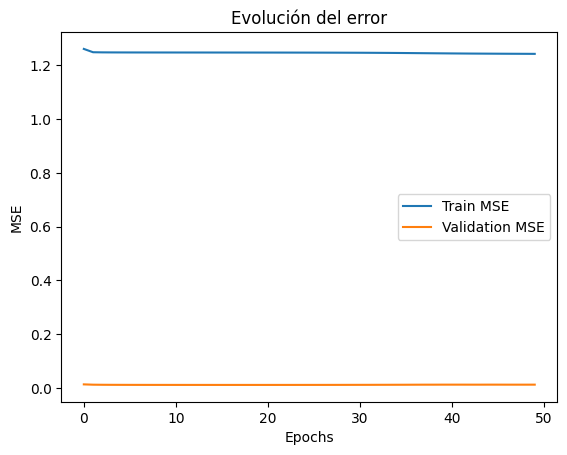

Errores por época (última fila = última epoch): [1.24195327 0.01271407]


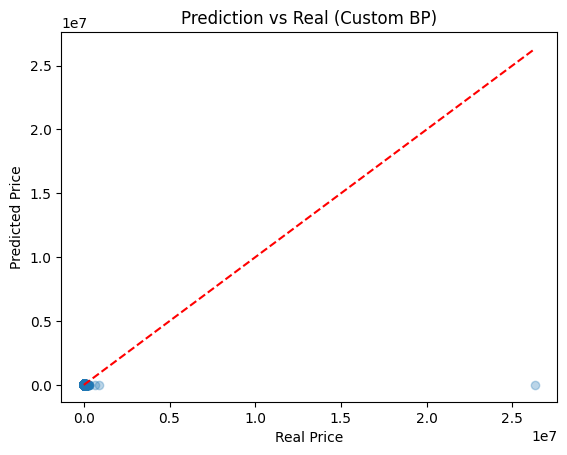

In [10]:
loss = nn.loss_epochs()
plt.plot(loss[:,0], label='Train MSE')
plt.plot(loss[:,1], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Evolución del error')
plt.legend()
plt.show()

print("Errores por época (última fila = última epoch):", loss[-1])

# ===================== Scatter plot: Predicted vs Real =====================
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # diagonal line y=x
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Prediction vs Real (Custom BP)')
plt.show()